<img src="https://steamcdn-a.akamaihd.net/apps/csgo/blog/images/wallpaper_nologo.jpg"/>

<center> <h1> Smart, not fair: An analysis of CS:GO metagame tactics </h1> </center>

<center> <h3> Anson Chen </h3> </center>

## Introduction:

One of the most popular genres in the growing video games  industry is the first person shooter (or FPS), in which players fight in first person by shooting other players. A common component to winning in these games is "mechanical skill", or the ability for a player to aim their crosshairs at enemy players with their mouse and hit them. One common belief that is held in the FPS community is that players with better mechanical skill are almost always the better players in general. That is, a player's skill level should be measured by their "mechanical skill" in games.  

To a point, this is a reasonable metric for player skill. To win most FPS games, you need to eliminate enemy players. Players with higher mechanical skill tend to hit more enemies, which naturally correlates with enemy eliminations. Thus you would assume that players with higher mechanical skill should win more.  

On the flip side of this coin, many of those same players who believe that mechanical skill is the most important metric for player skill also believe that winning for any other reason could be considered "unfair"; that players who have lower mechanical skill should not be able to beat players with higher mechanical skill unless they use "cheap" tactics. "Unfairness" could kill a burgeoning competitive esports scene if competitors no longer think the game is fair.

These tactics are generally referred to the metagame, which are generally specific to each game. For example, we'll take CS:GO (Counter-Strike: Global Offensive), the subject of this tutorial. CS:GO is a 5 vs 5 team-based tactical shooter, in which players take turns playing as the Terrorists (T) side and the Counter-Terrorists (CT) side. Terrorists need to take a C4 charge from their spawn and plant them on marked bomb sites on the map. If the C4 explodes, then the Terrorists win. Counter-Terrorists need to protect these bomb sites and keep the Terrorists from exploding them. Counter-Terrorists can win by either letting time run out without the terrorists planting the bomb or defuse the bomb after it is planted. For both sides, eliminating all enemy players will also win the game.

In this tutorial, we will look at trying to predict how factors might help players gain a competitive edge and win rounds. By analyzing the impact of different factors on winrate, we can determine whether or not "playing the metagame" gives an unfair advantage. This will be done by processing the data into a usable form, looking at trends in the data, and then finally building classification models to try and predict wins. Using our model, we will find that maybe those "unfair" factors aren't actually so unfair after all. 

# Libraries used

- *Pandas* for storing data : https://pandas.pydata.org/
- *NumPy* for efficiently manipulating data : https://numpy.org/
- *Scikit-Learn* for classification models : https://scikit-learn.org/stable/index.html
- *SciPy* for statistics libraries : https://www.scipy.org/

In [579]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from scipy import stats

# Default Python Modules
from collections import Counter
from functools import reduce

# 1. Data Preparation

Before we can do any analysis or exploration, we'll need to first find data that we can work with, and then process it in a way so that we can use it. The data that we'll be working with here is from Kaggle, a popular site to find datasets to use.

#### Source:

The link to the source of the data we'll be using can be found at https://www.kaggle.com/skihikingkevin/csgo-matchmaking-damage.

In this dataset, since it is all scraped data, we won't have many data quality issues, however we will have to deal with significant linking of data. One thing to note here is that every entry in our dataset represents a different incident that a player dealt/received damage. This is a long way away from us looking at individual round wins, so we'll have to put work into to aggregate rows so that we can look at our data on a per-round basis.

## 1.1 Importing Data

Taking the .csv files we downloaded from the Kaggle link, we're going to load them into Pandas so that we can manipulate them, and then show a couple rows of our new data gold so that we can get an idea of what we're working with.

In [523]:
df = pd.read_csv('mm_master_demos.csv');
df_nades = pd.read_csv('mm_grenades_demos.csv');
display(df.head())
display(df_nades.head())

,Unnamed: 0,file,map,date,round,tick,seconds,att_team,vic_team,att_side,...,vic_id,vic_rank,att_pos_x,att_pos_y,vic_pos_x,vic_pos_y,round_type,ct_eq_val,t_eq_val,avg_match_rank
0,0,003201673717864202280_0171883906.dem,de_dust2,09/28/2017 8:44:22 PM,1,8482,133.0582,Team 1,Team 2,CounterTerrorist,...,76561198123082770,17,1473.847,1351.358,662.170,772.748,PISTOL_ROUND,2950,3850,16.0
1,1,003201673717864202280_0171883906.dem,de_dust2,09/28/2017 8:44:22 PM,1,8600,134.9023,Team 1,Team 2,CounterTerrorist,...,76561198051040004,17,-1211.723,1060.813,-1184.006,1153.343,PISTOL_ROUND,2950,3850,16.0
2,2,003201673717864202280_0171883906.dem,de_dust2,09/28/2017 8:44:22 PM,1,8610,135.0586,Team 2,Team 1,Terrorist,...,76561198223006752,16,-1153.584,1163.131,-1198.015,1050.423,PISTOL_ROUND,2950,3850,16.0
3,3,003201673717864202280_0171883906.dem,de_dust2,09/28/2017 8:44:22 PM,1,8624,135.2774,Team 1,Team 2,CounterTerrorist,...,76561198051040004,17,-1173.053,1044.365,-1141.785,1190.089,PISTOL_ROUND,2950,3850,16.0
4,4,003201673717864202280_0171883906.dem,de_dust2,09/28/2017 8:44:22 PM,1,8632,135.4024,Team 2,Team 1,Terrorist,...,76561198223006752,16,-1142.522,1200.967,-1157.690,1050.702,PISTOL_ROUND,2950,3850,16.0


,Unnamed: 0,file,map,round,start_seconds,seconds,end_seconds,att_team,vic_team,att_id,...,att_pos_x,att_pos_y,nade_land_x,nade_land_y,vic_pos_x,vic_pos_y,round_type,ct_eq_val,t_eq_val,avg_match_rank
0,0,003201673717864202280_0171883906.dem,de_dust2,1,109.5534,125.1816,197.6025,Team 2,NaN,76561198244806730,...,-918.1018,-856.1255,257.32770,-435.8516,NaN,NaN,PISTOL_ROUND,2950,3850,16.0
1,1,003201673717864202280_0171883906.dem,de_dust2,1,109.5534,139.1844,197.6025,Team 2,NaN,76561198051040004,...,-1310.6070,1145.8650,-1124.67500,1216.9330,NaN,NaN,PISTOL_ROUND,2950,3850,16.0
2,2,003201673717864202280_0171883906.dem,de_dust2,1,109.5534,166.0649,197.6025,Team 2,Team 2,76561198147933469,...,-180.6393,327.6691,-89.53781,318.2151,-130.1585,304.0313,PISTOL_ROUND,2950,3850,16.0
3,3,003201673717864202280_0171883906.dem,de_dust2,2,197.6025,213.0431,281.2757,Team 1,NaN,76561198051106390,...,151.3117,2304.8010,-431.48370,2126.3900,NaN,NaN,ECO,12400,4700,16.0
4,4,003201673717864202280_0171883906.dem,de_dust2,2,197.6025,220.8572,281.2757,Team 1,NaN,76561198051106390,...,-1669.9540,2197.1340,-1955.98500,1384.2130,NaN,NaN,ECO,12400,4700,16.0


## 1.2 Organising our Data

Now we need to massage our data into forms that will be easier to use when we start trying to build features to use later. 

Luckily, because our data is scraped straight from game files, we won't have any egregious missing data issues, and the remaining missing data can be imputed relatively accurately using game defaults.

First of all we want to identify our data by the specific match they were played in, and the specific round of that match. Since each 'file' name is tied to a specific match, and the 'round' number is unique to the round it was played in, we will make a unique identifier here by combining the two so that we can link data together later. Ultimately, we want there to be only one entry corresponding to each round_id, which represents the specific round we want to look at.

In [524]:
df['round_id'] = df['file'] + ' ' + df['round'].apply(str)
df_nades['round_id'] = df_nades['file'] + ' ' + df_nades['round'].apply(str)

,Unnamed: 0,file,map,date,round,tick,seconds,att_team,vic_team,att_side,...,vic_id,vic_rank,att_pos_x,att_pos_y,vic_pos_x,vic_pos_y,round_type,ct_eq_val,t_eq_val,avg_match_rank
round_id,,,,,,,,,,,,,,,,,,,,,
003201673717864202280_0171883906.dem 1,0,003201673717864202280_0171883906.dem,de_dust2,09/28/2017 8:44:22 PM,1,8482,133.0582,Team 1,Team 2,CounterTerrorist,...,76561198123082770,17,1473.847,1351.358,662.170,772.748,PISTOL_ROUND,2950,3850,16.0
003201673717864202280_0171883906.dem 1,1,003201673717864202280_0171883906.dem,de_dust2,09/28/2017 8:44:22 PM,1,8600,134.9023,Team 1,Team 2,CounterTerrorist,...,76561198051040004,17,-1211.723,1060.813,-1184.006,1153.343,PISTOL_ROUND,2950,3850,16.0
003201673717864202280_0171883906.dem 1,2,003201673717864202280_0171883906.dem,de_dust2,09/28/2017 8:44:22 PM,1,8610,135.0586,Team 2,Team 1,Terrorist,...,76561198223006752,16,-1153.584,1163.131,-1198.015,1050.423,PISTOL_ROUND,2950,3850,16.0
003201673717864202280_0171883906.dem 1,3,003201673717864202280_0171883906.dem,de_dust2,09/28/2017 8:44:22 PM,1,8624,135.2774,Team 1,Team 2,CounterTerrorist,...,76561198051040004,17,-1173.053,1044.365,-1141.785,1190.089,PISTOL_ROUND,2950,3850,16.0
003201673717864202280_0171883906.dem 1,4,003201673717864202280_0171883906.dem,de_dust2,09/28/2017 8:44:22 PM,1,8632,135.4024,Team 2,Team 1,Terrorist,...,76561198223006752,16,-1142.522,1200.967,-1157.690,1050.702,PISTOL_ROUND,2950,3850,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
003235042038193848574_1296145074.dem 27,837,003235042038193848574_1296145074.dem,de_cbble,09/28/2017 2:08:52 PM,27,194142,3033.9980,Team 1,Team 2,Terrorist,...,76561198209959781,14,-2744.494,-1320.516,-1777.171,-1431.703,NORMAL,29250,28950,12.0
003235042038193848574_1296145074.dem 27,838,003235042038193848574_1296145074.dem,de_cbble,09/28/2017 2:08:52 PM,27,194258,3035.8110,Team 1,Team 2,Terrorist,...,76561198209959781,14,-2643.451,-1579.216,-1778.660,-1422.033,NORMAL,29250,28950,12.0
003235042038193848574_1296145074.dem 27,839,003235042038193848574_1296145074.dem,de_cbble,09/28/2017 2:08:52 PM,27,194270,3035.9980,Team 1,Team 2,Terrorist,...,76561198209959781,14,-2643.451,-1579.216,-1792.069,-1381.254,NORMAL,29250,28950,12.0


For convenience we're going to drop all the columns we don't need here. This way we can better see the remaining data in our tables.

In [525]:
df.columns

Index(['Unnamed: 0', 'file', 'map', 'date', 'round', 'tick', 'seconds',
       'att_team', 'vic_team', 'att_side', 'vic_side', 'hp_dmg', 'arm_dmg',
       'is_bomb_planted', 'bomb_site', 'hitbox', 'wp', 'wp_type', 'award',
       'winner_team', 'winner_side', 'att_id', 'att_rank', 'vic_id',
       'vic_rank', 'att_pos_x', 'att_pos_y', 'vic_pos_x', 'vic_pos_y',
       'round_type', 'ct_eq_val', 't_eq_val', 'avg_match_rank', 'round_id'],
      dtype='object')

In [526]:
df = df[['file', 'round_id', 'map', 'att_team', 'att_side', 'is_bomb_planted', 'hitbox', 'wp', \
         'wp_type', 'winner_team', 'winner_side', 'att_id', 'round_type', 'ct_eq_val', \
         't_eq_val', 'avg_match_rank']]
df_nades = df_nades[['round_id', 'att_team', 'att_id', 'nade', 'nade_land_x', 'nade_land_y']]

In [527]:
display(df.head())

,file,round_id,map,att_team,att_side,is_bomb_planted,hitbox,wp,wp_type,winner_team,winner_side,att_id,round_type,ct_eq_val,t_eq_val,avg_match_rank
0,003201673717864202280_0171883906.dem,003201673717864202280_0171883906.dem 1,de_dust2,Team 1,CounterTerrorist,False,Head,USP,Pistol,Team 1,CounterTerrorist,76561198085893650,PISTOL_ROUND,2950,3850,16.0
1,003201673717864202280_0171883906.dem,003201673717864202280_0171883906.dem 1,de_dust2,Team 1,CounterTerrorist,False,RightLeg,USP,Pistol,Team 1,CounterTerrorist,76561198223006752,PISTOL_ROUND,2950,3850,16.0
2,003201673717864202280_0171883906.dem,003201673717864202280_0171883906.dem 1,de_dust2,Team 2,Terrorist,False,LeftLeg,Glock,Pistol,Team 1,CounterTerrorist,76561198051040004,PISTOL_ROUND,2950,3850,16.0
3,003201673717864202280_0171883906.dem,003201673717864202280_0171883906.dem 1,de_dust2,Team 1,CounterTerrorist,False,Chest,USP,Pistol,Team 1,CounterTerrorist,76561198223006752,PISTOL_ROUND,2950,3850,16.0
4,003201673717864202280_0171883906.dem,003201673717864202280_0171883906.dem 1,de_dust2,Team 2,Terrorist,False,Chest,Glock,Pistol,Team 1,CounterTerrorist,76561198051040004,PISTOL_ROUND,2950,3850,16.0


As will be explained later, we're also going to remove the most unpopular maps due to small sample sizes in our analysis.

In [528]:
df['map'].unique()

array(['de_dust2', 'de_cache', 'de_inferno', 'de_mirage', 'de_cbble',
       'cs_agency', 'de_overpass', 'de_dust', 'de_train', 'de_austria',
       'de_nuke', 'cs_assault', 'de_thrill', 'de_blackgold',
       'cs_insertion', 'cs_office', 'de_shipped', 'de_vertigo',
       'de_canals', 'cs_italy', 'de_aztec'], dtype=object)

In [529]:
df_orig = df.copy()

# List of the popular maps we'll use
valid_maps = ['de_dust2', 'de_cache', 'de_inferno', 'de_mirage', 'de_cbble', 'de_overpass', 'de_nuke', 'de_train']
df = df[df['map'].isin(valid_maps)]

We also want to split our data based on opposing teams so we're going to split the data here to work on them separately before merging back together

In [532]:
df_team1 = df[df['att_team'] == 'Team 1']
df_team2 = df[df['att_team'] == 'Team 2']
df_nades1 = df_nades[df_nades['att_team'] == 'Team 1']
df_nades2 = df_nades[df_nades['att_team'] == 'Team 2']

In [533]:
display(df_team1.head(5))
display(df_team2.head(5))

,file,round_id,map,att_team,att_side,is_bomb_planted,hitbox,wp,wp_type,winner_team,winner_side,att_id,round_type,ct_eq_val,t_eq_val,avg_match_rank
0,003201673717864202280_0171883906.dem,003201673717864202280_0171883906.dem 1,de_dust2,Team 1,CounterTerrorist,False,Head,USP,Pistol,Team 1,CounterTerrorist,76561198085893650,PISTOL_ROUND,2950,3850,16.0
1,003201673717864202280_0171883906.dem,003201673717864202280_0171883906.dem 1,de_dust2,Team 1,CounterTerrorist,False,RightLeg,USP,Pistol,Team 1,CounterTerrorist,76561198223006752,PISTOL_ROUND,2950,3850,16.0
3,003201673717864202280_0171883906.dem,003201673717864202280_0171883906.dem 1,de_dust2,Team 1,CounterTerrorist,False,Chest,USP,Pistol,Team 1,CounterTerrorist,76561198223006752,PISTOL_ROUND,2950,3850,16.0
8,003201673717864202280_0171883906.dem,003201673717864202280_0171883906.dem 1,de_dust2,Team 1,CounterTerrorist,False,Stomach,USP,Pistol,Team 1,CounterTerrorist,76561198081341202,PISTOL_ROUND,2950,3850,16.0
9,003201673717864202280_0171883906.dem,003201673717864202280_0171883906.dem 1,de_dust2,Team 1,CounterTerrorist,False,Chest,USP,Pistol,Team 1,CounterTerrorist,76561198081341202,PISTOL_ROUND,2950,3850,16.0


,file,round_id,map,att_team,att_side,is_bomb_planted,hitbox,wp,wp_type,winner_team,winner_side,att_id,round_type,ct_eq_val,t_eq_val,avg_match_rank
2,003201673717864202280_0171883906.dem,003201673717864202280_0171883906.dem 1,de_dust2,Team 2,Terrorist,False,LeftLeg,Glock,Pistol,Team 1,CounterTerrorist,76561198051040004,PISTOL_ROUND,2950,3850,16.0
4,003201673717864202280_0171883906.dem,003201673717864202280_0171883906.dem 1,de_dust2,Team 2,Terrorist,False,Chest,Glock,Pistol,Team 1,CounterTerrorist,76561198051040004,PISTOL_ROUND,2950,3850,16.0
5,003201673717864202280_0171883906.dem,003201673717864202280_0171883906.dem 1,de_dust2,Team 2,Terrorist,False,Chest,Glock,Pistol,Team 1,CounterTerrorist,76561198051040004,PISTOL_ROUND,2950,3850,16.0
6,003201673717864202280_0171883906.dem,003201673717864202280_0171883906.dem 1,de_dust2,Team 2,Terrorist,False,Chest,Glock,Pistol,Team 1,CounterTerrorist,76561198051040004,PISTOL_ROUND,2950,3850,16.0
7,003201673717864202280_0171883906.dem,003201673717864202280_0171883906.dem 1,de_dust2,Team 2,Terrorist,False,Stomach,Glock,Pistol,Team 1,CounterTerrorist,76561198051040004,PISTOL_ROUND,2950,3850,16.0


## 1.3 Feature Engineering

Now we can start working on building features that we can analyze!

Some more exposition:

One of the most important components of CS:GO is the economy. Players can purchase weapons to fight with using in-game money. More money is received at the end of each round depending on how the team won or lost, and by completing objectives like eliminations and planting the bomb. Some of the more powerful guns cost more money, so it is in the player's best interest to earn money. As a result, this can lead to some metagame strategies such as planting a bomb just for the money bonus, or to intentionally lose rounds so that the team earns more money from the loss-streak and save up money from not buying guns.

This leads to our first area of exploration: weapon selection. Because of the large variety of guns, it would be reasonable to assume that weapon choice would have an impact on your chances to win.

### Weapons
We want to be able to identify which weapons each team used. Since every entry corresponds to a specific damage event, we need to be careful with how we count the number of weapons per team. For example, if a player hit someone 8 times with a USP pistol, there would be 8 separate entries for each hit. To account for this, we're going to assume that a player can only hold one of each weapon per round. That is, 8 separate entries for the USP will be condensed into the player holding one USP, not eight.

In [534]:
weapons_list = df['wp'].unique()
display(weapons_list)

array(['USP', 'Glock', 'P2000', 'HE', 'Tec9', 'Deagle', 'MP9', 'UMP',
       'Famas', 'P250', 'AK47', 'AWP', 'MP7', 'M4A1', 'FiveSeven',
       'Incendiary', 'Scout', 'Unknown', 'Knife', 'Bizon', 'Flash', 'CZ',
       'M4A4', 'Molotov', 'P90', 'AUG', 'Gallil', 'G3SG1', 'M249',
       'SG556', 'Mac10', 'XM1014', 'DualBarettas', 'Nova', 'Swag7',
       'Zeus', 'Scar20', 'SawedOff', 'Smoke', 'Negev', 'Decoy', 'Bomb'],
      dtype=object)

We want to group by 'att_id', or attacker id here as well because it will be unique to each player.

In [535]:
# Count a dictionary of unique weapons per player where the maximum value of each key-value pair is 1
def count_weapons(series):
    c = Counter()
    # Count only one of each weapon per player
    for i in series:
        c[i] = 1
    return c

# Aggregate the values of the entire subcategory
temp = df_team1.groupby(['round_id', 'att_id']).agg({'wp': count_weapons})
display(temp)

wp
round_id                                att_id                                   
003201673717864202280_0171883906.dem 1  76561198051106390            {'P2000': 1}
                                        76561198081341202              {'USP': 1}
                                        76561198085893650  {'USP': 1, 'Glock': 1}
                                        76561198223006752              {'USP': 1}
003201673717864202280_0171883906.dem 10 76561198051106390             {'AK47': 1}
...                                                                           ...
003235042038193848574_1296145074.dem 8  76561198149968597             {'M4A4': 1}
003235042038193848574_1296145074.dem 9  76561197961424834              {'AWP': 1}
                                        76561198049795311             {'M4A4': 1}
                                        76561198146367401             {'AK47': 1}
                                        76561198149968597             {'M4A4': 1}

[116083 rows x 1 columns]

Now we can combine the counts of the individual players to get a weapons list for the entire team.

In [537]:
# Combine dictionaries of player weapons into one aggregate
def combine_weapons(series):
    # Combine two dictionaries of weapon counts together
    return reduce(lambda x, y: x + y, series)

# Aggregate the values of the entire subcategory
df_weapons1 = temp.reset_index().groupby('round_id').agg({'wp': combine_weapons})
display(df_weapons1)

,wp
round_id,
003201673717864202280_0171883906.dem 1,"{'P2000': 1, 'USP': 3, 'Glock': 1}"
003201673717864202280_0171883906.dem 10,"{'AK47': 1, 'M4A1': 1, 'AWP': 1}"
003201673717864202280_0171883906.dem 11,"{'HE': 1, 'AK47': 2, 'Deagle': 1, 'M4A1': 1}"
003201673717864202280_0171883906.dem 12,"{'M4A1': 1, 'AWP': 2}"
003201673717864202280_0171883906.dem 13,{'AWP': 2}
...,...
003235042038193848574_1296145074.dem 5,"{'Famas': 1, 'Swag7': 1, 'XM1014': 1, 'MP9': 1..."
003235042038193848574_1296145074.dem 6,"{'Famas': 1, 'UMP': 1, 'XM1014': 1, 'M4A4': 2}"
003235042038193848574_1296145074.dem 7,"{'Swag7': 1, 'HE': 1, 'AK47': 1, 'M4A4': 1}"


Don't forget to do it for Team 2 as well!

In [538]:
temp = df_team2.groupby(['round_id', 'att_id']).agg({'wp': count_weapons})
df_weapons2 = temp.reset_index().groupby('round_id').agg({'wp': combine_weapons})
display(df_weapons2)
df_weapons1.columns = ['Team_1_Weapons']
df_weapons2.columns = ['Team_2_Weapons']

,wp
round_id,
003201673717864202280_0171883906.dem 1,"{'Glock': 3, 'HE': 1}"
003201673717864202280_0171883906.dem 10,"{'Tec9': 1, 'AK47': 1}"
003201673717864202280_0171883906.dem 11,"{'Tec9': 1, 'Glock': 1, 'Deagle': 1, 'P250': 1..."
003201673717864202280_0171883906.dem 12,"{'AWP': 3, 'Deagle': 1, 'Scout': 1, 'M4A1': 1}"
003201673717864202280_0171883906.dem 13,"{'AWP': 1, 'AK47': 1}"
...,...
003235042038193848574_1296145074.dem 5,"{'SG556': 1, 'HE': 1, 'AK47': 2}"
003235042038193848574_1296145074.dem 6,"{'P90': 1, 'Gallil': 1, 'AK47': 2}"
003235042038193848574_1296145074.dem 7,"{'HE': 1, 'P250': 1}"


Just for good measure, we're also going to apply this idea to weapon types (i.e. is the player using a pistol or a rifle). This can be used later for more general trends compared to individual weapons.

In [539]:
temp = df_team1.groupby(['round_id', 'att_id']).agg({'wp_type': count_weapons})
display(temp)

wp_type
round_id                                att_id                          
003201673717864202280_0171883906.dem 1  76561198051106390  {'Pistol': 1}
                                        76561198081341202  {'Pistol': 1}
                                        76561198085893650  {'Pistol': 1}
                                        76561198223006752  {'Pistol': 1}
003201673717864202280_0171883906.dem 10 76561198051106390   {'Rifle': 1}
...                                                                  ...
003235042038193848574_1296145074.dem 8  76561198149968597   {'Rifle': 1}
003235042038193848574_1296145074.dem 9  76561197961424834  {'Sniper': 1}
                                        76561198049795311   {'Rifle': 1}
                                        76561198146367401   {'Rifle': 1}
                                        76561198149968597   {'Rifle': 1}

[116083 rows x 1 columns]

In [540]:
# Aggregate the values of the entire subcategory
df_wptype1 = temp.reset_index().groupby('round_id').agg({'wp_type': combine_weapons})


temp = df_team2.groupby(['round_id', 'att_id']).agg({'wp_type': count_weapons})
df_wptype2 = temp.reset_index().groupby('round_id').agg({'wp_type': combine_weapons})

df_wptype1.columns = ['Team_1_Weapon_Types']
df_wptype2.columns = ['Team_2_Weapon_Types']
display(df_wptype1)

,Team_1_Weapon_Types
round_id,
003201673717864202280_0171883906.dem 1,{'Pistol': 4}
003201673717864202280_0171883906.dem 10,"{'Rifle': 2, 'Sniper': 1}"
003201673717864202280_0171883906.dem 11,"{'Grenade': 1, 'Rifle': 3, 'Pistol': 1}"
003201673717864202280_0171883906.dem 12,"{'Rifle': 1, 'Sniper': 2}"
003201673717864202280_0171883906.dem 13,{'Sniper': 2}
...,...
003235042038193848574_1296145074.dem 5,"{'Rifle': 3, 'Heavy': 2, 'SMG': 1}"
003235042038193848574_1296145074.dem 6,"{'Rifle': 3, 'SMG': 1, 'Heavy': 1}"
003235042038193848574_1296145074.dem 7,"{'Heavy': 1, 'Grenade': 1, 'Rifle': 2}"


### Headshot Percentage

Next we're going to try to get a headshot percentage to see if that impacts winrate. This will be used as a metric to measure "mechanical skill". In this case, headshots will be a proxy for "mechanical skill". In CS:GO, shooting enemies in the head does more damage compared to other bodyparts. As a result, it would be reasonable to assume that players with high mechanical skill would go for headshots to gain a competitive edge. Thus, high headshot percentage would be correlated with high mechanical skill.

In [541]:
df_team1['hitbox'].unique()

array(['Head', 'RightLeg', 'Chest', 'Stomach', 'RightArm', 'LeftLeg',
       'LeftArm', 'Generic'], dtype=object)

Notice that one of the options is generic, which represents general damage like grenades. Since this isn't damage caused by aiming, we will ignore these when calculating our headshot percentage.

In [542]:
# aggregation function for calculating headshot percentage

def hs_percentage(series):
    hs = 0
    total = 0
    for i in series:
        if i == 'Head':
            hs += 1
        # Ignore generic damage here
        if i != 'Generic':
            total += 1
    if total != 0:
        return hs/total
    else:
        return 0

# Aggregate the values of the entire subcategory
df_hs1 = df_team1.groupby('round_id').agg({'hitbox': hs_percentage})
df_hs2 = df_team2.groupby('round_id').agg({'hitbox': hs_percentage})

df_hs1.columns = ['Team_1_hs_percentage']
df_hs2.columns = ['Team_2_hs_percentage']

display(df_hs1)

,Team_1_hs_percentage
round_id,
003201673717864202280_0171883906.dem 1,0.200000
003201673717864202280_0171883906.dem 10,0.300000
003201673717864202280_0171883906.dem 11,0.272727
003201673717864202280_0171883906.dem 12,0.250000
003201673717864202280_0171883906.dem 13,0.400000
...,...
003235042038193848574_1296145074.dem 5,0.071429
003235042038193848574_1296145074.dem 6,0.037037
003235042038193848574_1296145074.dem 7,0.142857


### Equipment Value

Following from before, we now want to see if having more money (buying more expensive equipment) leads to winning more rounds. To do this, we'll need to select the correct money data for each team. Since the data only has money listed for the CT or T side, we need to correctly identify if the team we're looking at is CT or T.

In [543]:
df_cost1 = df_team1.drop_duplicates('round_id')[['round_id', 'att_side', 'ct_eq_val', 't_eq_val']]
df_cost2 = df_team2.drop_duplicates('round_id')[['round_id', 'att_side', 'ct_eq_val', 't_eq_val']]

def pick_cost(row):
    # If team is CT pick ct_eq_val, otherwise pick t_eq_val, simple!
    if row['att_side'] == 'CounterTerrorist':
        return row['ct_eq_val']
    else:
        return row['t_eq_val']

# Apply our function pick_cost to each row
df_cost1['Team_1_Cost'] = df_cost1.apply(pick_cost, axis=1)
df_cost2['Team_2_Cost'] = df_cost2.apply(pick_cost, axis=1)

df_cost1 = df_cost1[['round_id', 'Team_1_Cost']]
df_cost2 = df_cost2[['round_id', 'Team_2_Cost']]

df_cost1 = df_cost1.set_index('round_id')
df_cost2 = df_cost2.set_index('round_id')

display(df_cost1.head())

,Team_1_Cost
round_id,
003201673717864202280_0171883906.dem 1,2950
003201673717864202280_0171883906.dem 2,12400
003201673717864202280_0171883906.dem 3,4700
003201673717864202280_0171883906.dem 4,9200
003201673717864202280_0171883906.dem 5,10700


### Grenades

We also want to look at the tactical use of grenades. In CS:GO you can also choose to purchase grenades at the start of each round. Besides the normal explosive grenade that damages players nearby, there are also smoke grenades which can deny vision to important areas of the map, and flash grenades which can be used to temporarily blind enemy players as an opening. The use of grenades (especially smokes) is a very important gameplay mechanic to CS:GO, so this is another area that we would to explore.

In [544]:
# aggregation function for counting each type of grenade in a dictionary
def count_nades(series):
    c = Counter()
    for i in series:
        c[i] += 1
    return c

# Aggregate the values of the entire subcategory
df_nadecounts1 = df_nades1.groupby('round_id').agg({'nade': count_nades})
df_nadecounts2 = df_nades2.groupby('round_id').agg({'nade': count_nades})
df_nadecounts1.columns = ['Team_1_Nades']
df_nadecounts2.columns = ['Team_2_Nades']

display(df_nadecounts1.head(5))
display(df_nadecounts2.head(5))

,Team_1_Nades
round_id,
003201673717864202280_0171883906.dem 10,"{'Smoke': 1, 'HE': 2, 'Flash': 1}"
003201673717864202280_0171883906.dem 11,"{'Smoke': 1, 'HE': 3}"
003201673717864202280_0171883906.dem 12,"{'Smoke': 2, 'HE': 2, 'Flash': 2}"
003201673717864202280_0171883906.dem 13,"{'Smoke': 1, 'HE': 1, 'Flash': 1}"
003201673717864202280_0171883906.dem 14,"{'Smoke': 1, 'Decoy': 1}"


,Team_2_Nades
round_id,
003201673717864202280_0171883906.dem 1,"{'Decoy': 2, 'HE': 1}"
003201673717864202280_0171883906.dem 10,"{'Smoke': 1, 'HE': 1, 'Flash': 2}"
003201673717864202280_0171883906.dem 11,{'Flash': 1}
003201673717864202280_0171883906.dem 12,"{'Smoke': 1, 'Decoy': 1, 'Flash': 4}"
003201673717864202280_0171883906.dem 13,"{'Flash': 4, 'Decoy': 1, 'Smoke': 2, 'HE': 1}"


In [545]:
df_nades['nade'].unique()

array(['Decoy', 'HE', 'Smoke', 'Flash', 'Molotov', 'Incendiary'],
      dtype=object)

### Data Merging

Now we're ready to link everything together! Using our round_id from before, we should be able to just join everything together using the common round_id. Something to note here is that some round data is repeated multiple times (like the equipment value data). To preserve this data, we're just going to drop all duplicates except the first (since this will correspond to the start of the round). Then we'll join everything together afterwards.

In [546]:
df_merge = df.drop_duplicates('round_id')

#new_df = [df_cost1, df_cost2, df_hs1, df_hs2, df_weapons1, df_weapons2, df_wptype1, df_wptype2, \
#          df_nadecounts1, df_nadecounts2]

# For some reason python doesn't like looping so this is commented out
#for i in new_df:
#    df_merge = df_merge.join(i, on='round_id', how='left', rsuffix="_n")

df_merge = df_merge.join(df_cost1, on='round_id', how='left', rsuffix="_n")
df_merge = df_merge.join(df_cost2, on='round_id', how='left', rsuffix="_n")
df_merge = df_merge.join(df_hs1, on='round_id', how='left', rsuffix="_n")
df_merge = df_merge.join(df_hs2, on='round_id', how='left', rsuffix="_n")
df_merge = df_merge.join(df_weapons1, on='round_id', how='left', rsuffix="_n")
df_merge = df_merge.join(df_weapons2, on='round_id', how='left', rsuffix="_n")
df_merge = df_merge.join(df_wptype1, on='round_id', how='left', rsuffix="_n")
df_merge = df_merge.join(df_wptype2, on='round_id', how='left', rsuffix="_n")
df_merge = df_merge.join(df_nadecounts1, on='round_id', how='left', rsuffix="_n")
df_merge = df_merge.join(df_nadecounts2, on='round_id', how='left', rsuffix="_n")

We're also going to leave out the remaining columns that we didn't use.

In [547]:
df_merge = df_merge[['round_id', 'map', 'winner_team', 'winner_side', 'round_type', 'avg_match_rank', \
                     'Team_1_Weapons', 'Team_2_Weapons', 'Team_1_hs_percentage', 'Team_2_hs_percentage', \
                     'Team_1_Weapon_Types', 'Team_1_Weapon_Types', 'Team_1_Cost', 'Team_2_Cost', \
                     'Team_1_Nades', 'Team_2_Nades']]

For convenience, we're also going to code our winning team as a dummy variable here. In this case, 1 represents that Team 1 won and 0 represents that Team 1 lost. This can be reversed for Team 2 since a loss for Team 1 is a win for Team 2.

In [548]:
def dummy_winner(t):
    if t == 'Team 1':
        return 1
    else:
        return 0
    
# Apply our dummy_winner function to every entry in 'winner_team'
df_merge['winner_team_1'] = df['winner_team'].map(dummy_winner)

display(df_merge.head())

,round_id,map,winner_team,winner_side,round_type,avg_match_rank,Team_1_Weapons,Team_2_Weapons,Team_1_hs_percentage,Team_2_hs_percentage,Team_1_Weapon_Types,Team_1_Weapon_Types,Team_1_Cost,Team_2_Cost,Team_1_Nades,Team_2_Nades,winner_team_1
0,003201673717864202280_0171883906.dem 1,de_dust2,Team 1,CounterTerrorist,PISTOL_ROUND,16.0,"{'P2000': 1, 'USP': 3, 'Glock': 1}","{'Glock': 3, 'HE': 1}",0.200000,0.250000,{'Pistol': 4},{'Pistol': 4},2950.0,3850.0,NaN,"{'Decoy': 2, 'HE': 1}",1
28,003201673717864202280_0171883906.dem 2,de_dust2,Team 2,Terrorist,ECO,16.0,"{'UMP': 1, 'Deagle': 2, 'MP9': 1, 'Famas': 1}","{'Tec9': 2, 'UMP': 1, 'Deagle': 2, 'P250': 1}",0.222222,0.176471,"{'SMG': 2, 'Pistol': 2, 'Rifle': 1}","{'SMG': 2, 'Pistol': 2, 'Rifle': 1}",12400.0,4700.0,"{'Smoke': 1, 'HE': 1}","{'Smoke': 1, 'Flash': 1}",0
54,003201673717864202280_0171883906.dem 3,de_dust2,Team 2,Terrorist,ECO,16.0,"{'P250': 1, 'Deagle': 2, 'USP': 2}","{'HE': 2, 'UMP': 1, 'Famas': 1, 'AK47': 2}",0.307692,0.153846,{'Pistol': 5},{'Pistol': 5},4700.0,21050.0,{'Flash': 1},"{'Smoke': 2, 'HE': 3, 'Flash': 3, 'Molotov': 1}",0
82,003201673717864202280_0171883906.dem 4,de_dust2,Team 2,Terrorist,SEMI_ECO,16.0,{'Deagle': 4},"{'HE': 2, 'UMP': 1, 'AK47': 2, 'AWP': 1, 'Deag...",0.428571,0.090909,{'Pistol': 4},{'Pistol': 4},9200.0,24250.0,"{'Smoke': 1, 'HE': 1, 'Flash': 2}","{'Smoke': 3, 'HE': 4, 'Flash': 2, 'Molotov': 1}",0
103,003201673717864202280_0171883906.dem 5,de_dust2,Team 2,Terrorist,SEMI_ECO,16.0,"{'FiveSeven': 1, 'M4A1': 1, 'Deagle': 2}","{'MP7': 1, 'AK47': 2, 'Deagle': 1}",0.500000,0.052632,"{'Pistol': 3, 'Rifle': 1}","{'Pistol': 3, 'Rifle': 1}",10700.0,25750.0,"{'Smoke': 1, 'Flash': 2, 'HE': 1}","{'Flash': 4, 'Smoke': 2, 'HE': 1}",0


### Maps

Finally, different maps that players play on might also have an impact on winrate. Since Terrorists and Counter-Terrorists have different objectives, one could reasonably assume that certain maps might favor one side versus the other. For example, the map de_nuke is notorious for being CT-sided. That is, de_nuke winrates are overwhelmingly in favor of Counter-Terrorists because the bombsites are much easier to defend and harder to attack. This data is already in our dataframe so we can leave this alone.

#  2. Exploratory Data Analysis

Now we can look at our data in a little more detail!

## 2.1 Maps

First we're going to look at the maps that players choose to play on. We'll drop duplicates based on file so that we only have 1 entry per match, and then we'll plot to see map trends. First we'll work with our unprocessed data.

Text(0.5, 1.0, 'Distribution of Maps Played (Original)')

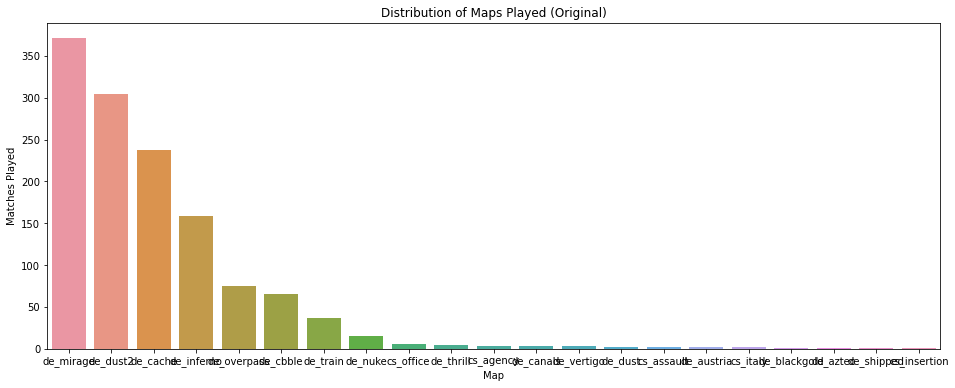

In [590]:
map_pref = df_orig.drop_duplicates('file')
map_pref = map_pref.groupby(['map']).count().reset_index().sort_values('round_id', ascending=False)
plt.figure(figsize=(16,6))
ax = sns.barplot(x='map', y='round_id', data=map_pref)

ax.set_xlabel('Map')
ax.set_ylabel('Matches Played')
ax.set_title('Distribution of Maps Played (Original)')

Notice here that a lot of the maps have very few observations! This is why we dropped them earlier on when we were processing our data. Plotting our processed data below we see that our sample sizes are much more manageable after processing.

Text(0.5, 1.0, 'Distribution of Maps Played (Cleaned)')

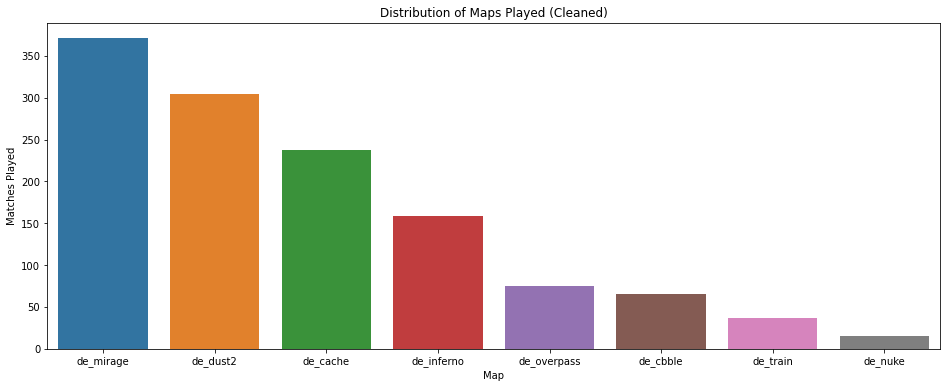

In [589]:
map_pref = df.drop_duplicates('file')
map_pref = map_pref.groupby(['map']).count().reset_index().sort_values('round_id', ascending=False)
plt.figure(figsize=(16,6))
ax = sns.barplot(x='map', y='round_id', data=map_pref)

ax.set_xlabel('Map')
ax.set_ylabel('Matches Played')
ax.set_title('Distribution of Maps Played (Cleaned)')

### Map Imbalance

Here we'll look at "T-sidedness", or the tendency for a map to be favorable for one side versus another.

Text(0.5, 1.0, 'Win Percentage Skewed in Favor of Counter-Terrorists')

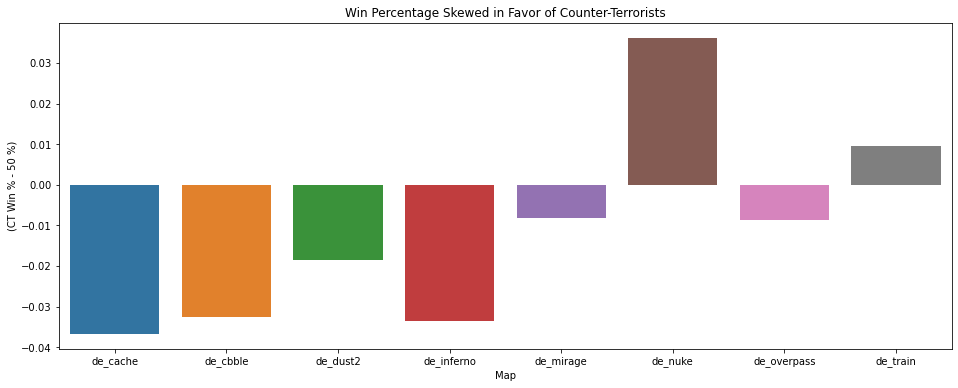

In [602]:
# Calculate the win_rate for Counter-Terrorists
def agg_wr(series):
    ct_wins = 0
    total = 0
    for i in series:
        if i == 'CounterTerrorist':
            ct_wins += 1
        total += 1
    return ct_wins / total

map_skew = df
map_skew = map_skew.groupby('map').agg({'winner_side': agg_wr}).reset_index()
map_skew['winner_side'] = map_skew['winner_side'] - 0.5
map_skew.columns = ['Map', 'Win Skew Percentage']

plt.figure(figsize=(16,6))
ax = sns.barplot(x='Map', y='Win Skew Percentage', data=map_skew)

ax.set_xlabel('Map')
ax.set_ylabel('(CT Win % - 50 %)')
ax.set_title('Win Percentage Skewed in Favor of Counter-Terrorists')

We notice here that most maps are actually pretty balanced! Most of the maps only have a winrate difference of 5% from 50%. A key map to notice here is de_nuke, where de_nuke is more than 30% in favor of Counter-Terrorist wins! Of course, this idea should be tempered by the fact that we saw above that de_nuke had a small sample size of less than 20 matches (which could very well be related to the map imbalance). We should also note here that most maps tend to be slightly in favor of Terrorists from between 2-4%.

## 2.2 Guns

Before we start looking at guns, we'll want to consider how the distribution of guns can differ in different ranks. Assuming that players in higher ranks are actually better, we can get an idea of guns that "better" players use.

<img src='https://csgosmurfninja.com/wp-content/uploads/2019/12/rank_2018-2-300x225.jpg.webp'>

Looking at the progression of ranks above, we can assume that ranks start at 1 for Silver I. Our lowest rank recorded here is 7, and our highest rank recorded here is 16. Using our mapping from before, we assume that our ranks fall between Gold Nova I (7), and Legendary Eagle Master (16)

In [553]:
df['avg_match_rank'].unique()

array([16., 10., 12., 11., 14., 15.,  9.,  8., 13.,  7.])

Using some prior knowledge, the majority of players fall in Gold Nova 1 - 4 with a bell curve. To roughly divide our dataset into two skill groups, we'll place Gold Nova 1 - 4 into the 'GN' group, and place the rest into the 'MG' group.

In [556]:
def tag_rank(rank):
    mappings = {
        7: 'GN',
        8: 'GN',
        9: 'GN',
        10: 'GN',
        11: 'MG',
        12: 'MG',
        13: 'MG',
        14: 'MG',
        15: 'MG',
        16: 'MG',
    }
    
    return mappings[rank]

For our distribution here, we also don't really care about which team the weapons belong to, so we'll combine them together.

In [558]:
# Similar to above, combine weapons lists!
def weapon_sum(series):
    count = Counter()
    for i in series:
        if isinstance(i, Counter):
            count += i
    return count

df_wpdist = df_merge
df_wpdist['rank_tag'] = df_wpdist['avg_match_rank'].map(tag_rank)
df_wpdist['Weapons'] = df_wpdist['Team_1_Weapons'] + df_wpdist['Team_2_Weapons']

df_wpdist = df_wpdist.groupby('rank_tag').agg({'Weapons': weapon_sum})
display(df_wpdist.head())

,Weapons
rank_tag,
GN,"{'P2000': 1193, 'USP': 7582, 'Tec9': 1675, 'Gl..."
MG,"{'P2000': 1548, 'USP': 8226, 'Glock': 6623, 'H..."


Notice that we now have two dictionaries, one for each skill group, that represents our counts for weapons. Here, we convert them into dataframes that we can use to plot the data, and also tag the weapons into different groups so that we can separate them later.

In [559]:
# Separate out our GN and MG data into two separate dataframes
gn_wpdist = pd.DataFrame.from_dict(df_wpdist['Weapons'][0], orient='index').reset_index()
gn_wpdist.columns = ['Weapons', 'Count']
gn_wpdist = gn_wpdist.sort_values('Count', ascending=False)

mg_wpdist = pd.DataFrame.from_dict(df_wpdist['Weapons'][1], orient='index').reset_index()
mg_wpdist.columns = ['Weapons', 'Count']
mg_wpdist = mg_wpdist.sort_values('Count', ascending=False)

pistol_list = ['P2000', 'USP', 'Tec9', 'Glock', 'P250', 'CZ', 'DualBarettas']
smg_list = ['MP9', 'UMP', 'Bizon', 'MP7', 'P90', 'Mac10']
shotgun_list = ['XM1014', 'Nova', 'Swag7', 'SawedOff']
lmg_list = ['M249', 'Negev']
rifle_list = ['M4A1', 'M4A4', 'AK47', 'AUG', 'Gallil', 'SG556', 'Famas']
sniper_list = ['AWP', 'Scout', 'G3SG1', 'Scar20']

# Tag each weapon by weapon class
def weapon_tag(s):
    if s in pistol_list:
        return 'pistol'
    elif s in smg_list:
        return 'smg'
    elif s in shotgun_list:
        return 'shotgun'
    elif s in lmg_list:
        return 'lmg'
    elif s in rifle_list:
        return 'rifle'
    elif s in sniper_list:
        return 'sniper'
    else:
        return 'other'
        
gn_wpdist['Weapon_Tag'] = gn_wpdist['Weapons'].apply(weapon_tag)
mg_wpdist['Weapon_Tag'] = mg_wpdist['Weapons'].apply(weapon_tag)

Now we can plot our data! Here we're going to separate it so that for each group of weapons, the Gold Nova or GN skill group is plotted on the left and the higher "Master Guardian" or MG group is plotted on the left.

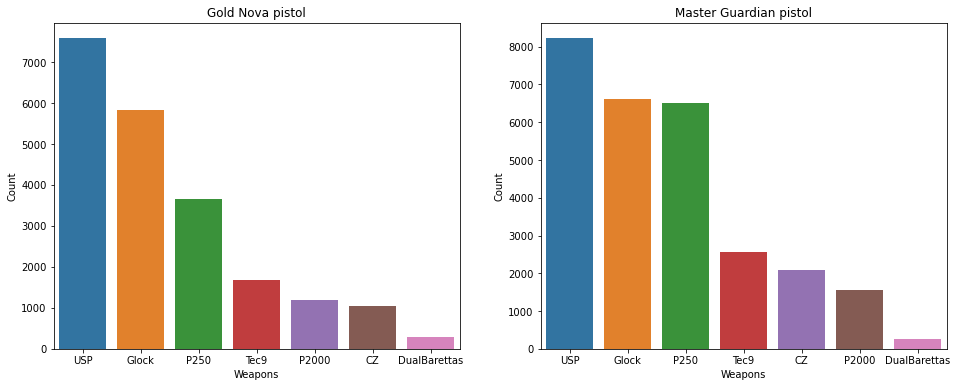

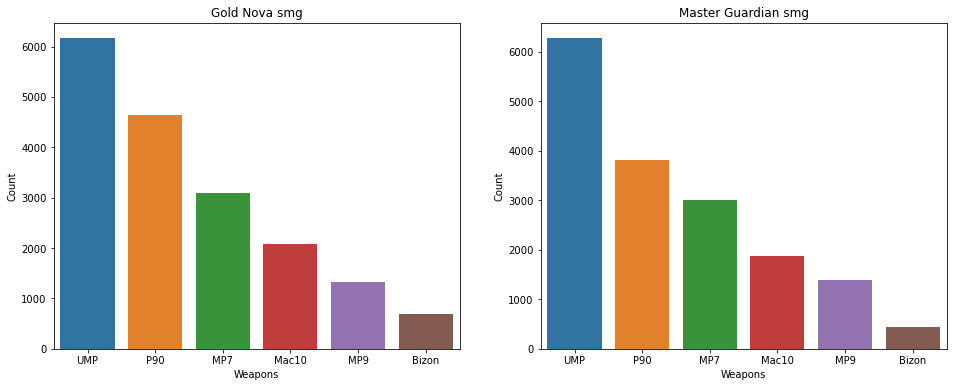

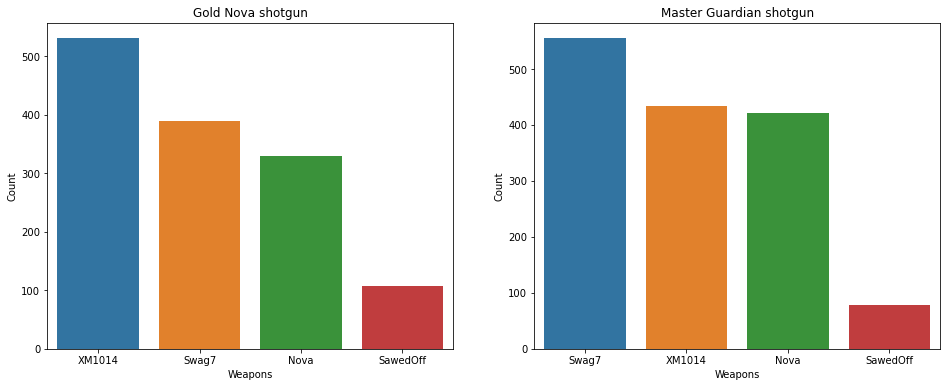

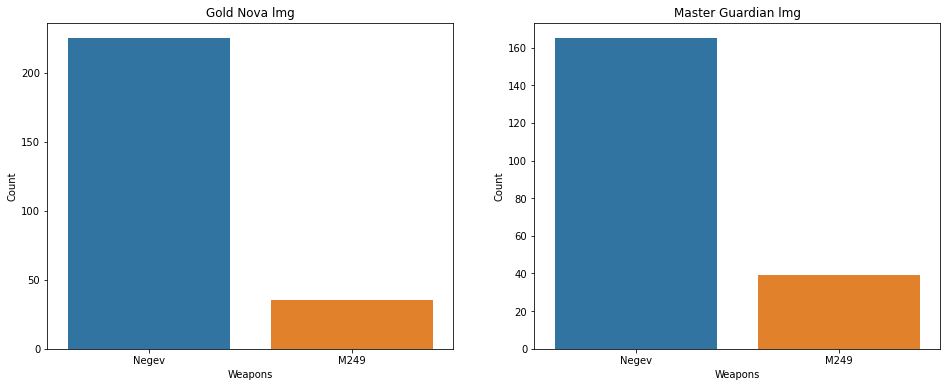

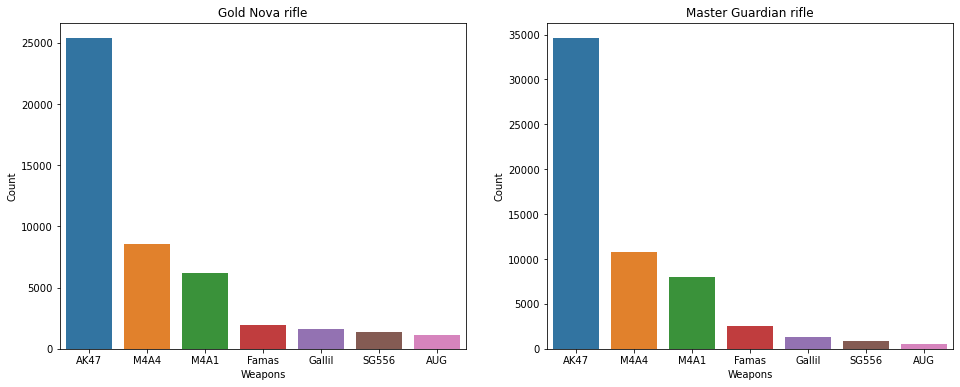

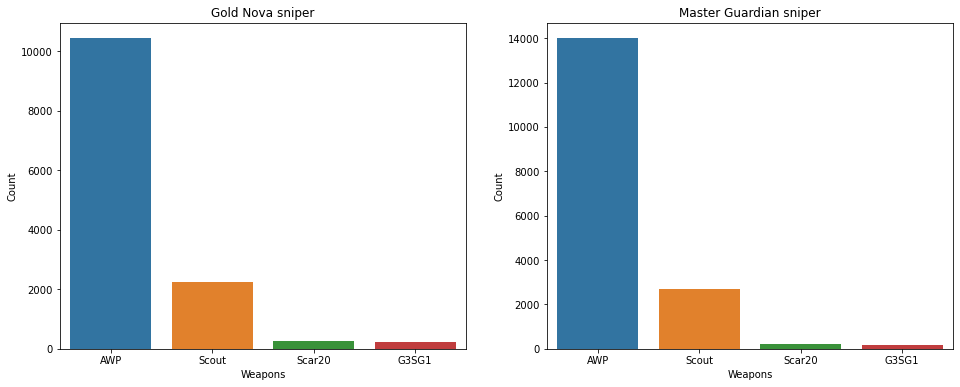

In [560]:
typelist = ['pistol', 'smg', 'shotgun', 'lmg', 'rifle', 'sniper']

for wp_type in typelist:
    fig, axs = plt.subplots(1, 2, figsize=(16,6))
    sns.barplot(x='Weapons', y='Count', data=gn_wpdist[gn_wpdist['Weapon_Tag'] == wp_type], ax=axs[0])
    axs[0].set_title('Gold Nova ' + wp_type)
    
    sns.barplot(x='Weapons', y='Count', data=mg_wpdist[mg_wpdist['Weapon_Tag'] == wp_type], ax=axs[1])
    axs[1].set_title('Master Guardian ' + wp_type)

An interesting difference between the skill levels to point out here is for shotguns. While the most popular shotgun for Gold Nova players is the XM1014, the most popular shotgun for MG players is the MAG7 (aka Swag7). The XM1014 is known for being a notoriously "noob-friendly" gun, so its decline in upper skill levels is telling here.

In terms of general trends, we notice that the most favored pistol is the USP, the most favored SMG is the UMP, the most favored rifle is the AK47, and the most favored sniper is the AWP. One could reasonably infer here that the most popular guns are chosen for being the best in their class, so choosing these top picks would be the best choices.

## 2.3 Grenades

Now we're going to look at the distribution of grenades used by round and how it affects winrate. 

First we'll strip the team labelings and turn them into dataframes so that we can directly map the number of nades thrown to a dummy variable indicating whether or not the round was a win.

In [569]:
# Return the total number of nades counted
def count_nades(c):
    if isinstance(c, Counter):
        return sum(c.values())
    else:
        return 0

nades = pd.DataFrame()

# 'Stack' the rows so that the first n rows represent Team 1's data, and the next n rows represents Team 2's data
nades['nade_count'] = pd.concat([ \
                                 df_merge['Team_1_Nades'].map(count_nades), \
                                 df_merge['Team_2_Nades'].map(count_nades)
                                ])

nades['win'] = pd.concat([ \
                          df_merge['winner_team_1'], \
                          df_merge['winner_team_1'].map(lambda x: 0 if x == 1 else 1) \
                         ])


Here we notice that most teams throw less than 5 grenades, while the frequency of grenade count significantly tapers off as it increases.

Text(0.5, 1.0, 'Distribution of Number of Grenades Thrown')

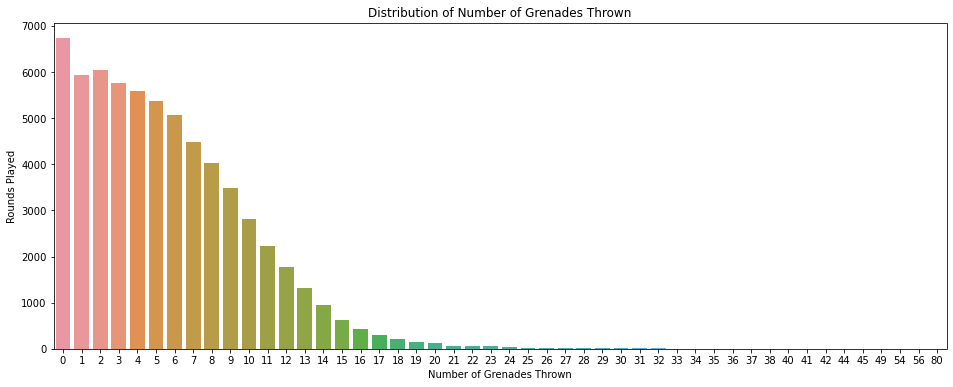

In [594]:
nade_count = nades.groupby('nade_count').count().reset_index()

plt.figure(figsize=(16,6))
ax = sns.barplot(x='nade_count', y='win', data=nade_count)

ax.set_xlabel('Number of Grenades Thrown')
ax.set_ylabel('Rounds Played')
ax.set_title('Distribution of Number of Grenades Thrown')

Looking at the distribution here, we notice the conclusion we expected earlier here. Almost all rounds where the team threw more than 5 grenades have winrates over 50%. Most notably, teams that throw 0 grenades have a shockingly bad mean winrate of less than 30%. This suggests that better teams tend to throw more grenades, which correlates with higher winrates. Of course, incresing winrate by throwing grenades should be within reason, since just randomly throwing grenades does not lead to a higher chance of winning (correlation is not causation!).

Text(0.5, 1.0, 'Average Win Percentage vs. Number of Grenades Thrown')

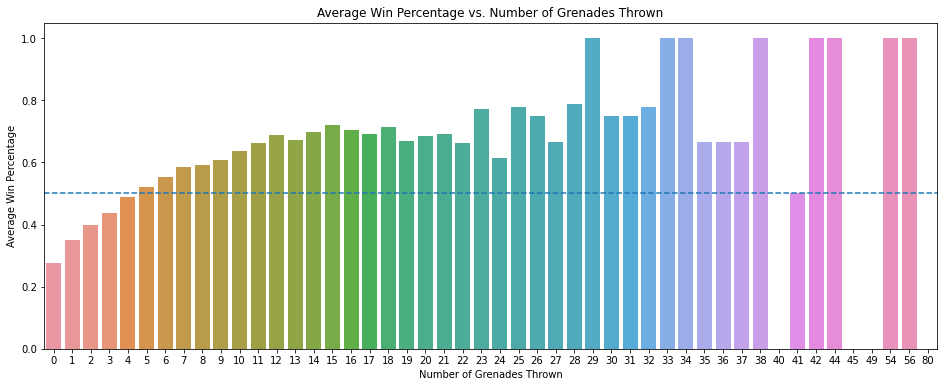

In [595]:
nade_wr = nades.groupby('nade_count').mean().reset_index()

plt.figure(figsize=(16,6))
ax = sns.barplot(x='nade_count', y='win', data=nade_wr)
ax.axhline(0.5, linestyle='--')
ax.set_xlabel('Number of Grenades Thrown')
ax.set_ylabel('Average Win Percentage')
ax.set_title('Average Win Percentage vs. Number of Grenades Thrown')

## 2.4 Equipment Value

Again, we'll look at the distribution of the equipment value for teams and how it affects winrates. Here we notice that distribution of equipment value is bimodal, with most teams either having the stock equipment value, or full buying a complete loadout.

Text(0.5, 1.0, 'Distribution of Equipment Value')

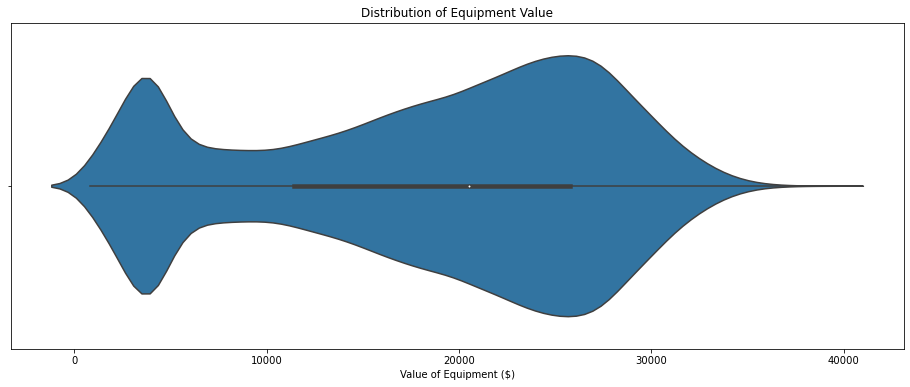

In [596]:
evalue = pd.DataFrame()

# 'Stack' the rows so that the first n rows represent Team 1's data, and the next n rows represents Team 2's data
evalue['equipment_value'] = pd.concat([ \
                                 df_merge['Team_1_Cost'], \
                                 df_merge['Team_2_Cost']
                                ])

evalue['win'] = pd.concat([ \
                          df_merge['winner_team_1'], \
                          df_merge['winner_team_1'].map(lambda x: 0 if x == 1 else 1) \
                         ])

plt.figure(figsize=(16,6))
ax = sns.violinplot(x='equipment_value', data=evalue)
ax.set_xlabel('Value of Equipment ($)')
ax.set_title('Distribution of Equipment Value')

As expected from our exposition, lower equipment values does correlate to worse winrates. More importantly, we notice that the win_rate for teams that don't commit to full saving (i.e. not everyone saves all their money by not buying anything) is actually worse than teams that save all their money. It isn't until the loadout value indicates that at least most of the team can buy full loadouts that we see the winrate go over 50%.

This tells us something that people have long been trying to say: it is better to save all your money for a full loadout later, than to constantly waste your money and never have enough.

Text(0.5, 1.0, 'Equipment Value vs. Win Percentage ')

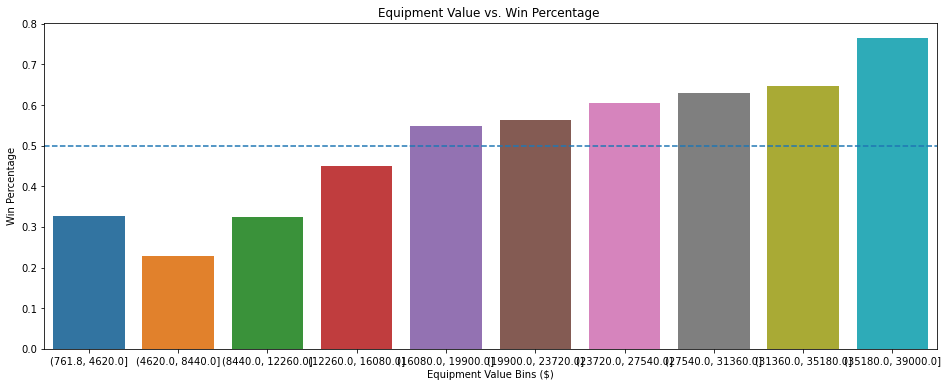

In [598]:
# Bin the data so we can calculate average win rates
evalue['bin'] = pd.cut(x=evalue['equipment_value'], bins=10)
equip_wr = evalue.groupby('bin').mean().reset_index()

plt.figure(figsize=(16,6))
ax = sns.barplot(x='bin', y='win', data=equip_wr)
ax.axhline(0.5, linestyle='--')
ax.set_xlabel('Equipment Value Bins ($)')
ax.set_ylabel('Win Percentage')
ax.set_title('Equipment Value vs. Win Percentage ')

## 2.5 Headshot Percentage

Finally we'll look at headshot percentage. We'll be using the same method as we used above for equipment value above. Here we notice in our violin plot that the distribution is bimodal, with most teams having either a 0% headshot percentage, or a headshot percentage around 10-20%.

Text(0.5, 1.0, 'Distribution of Headshot Percentages')

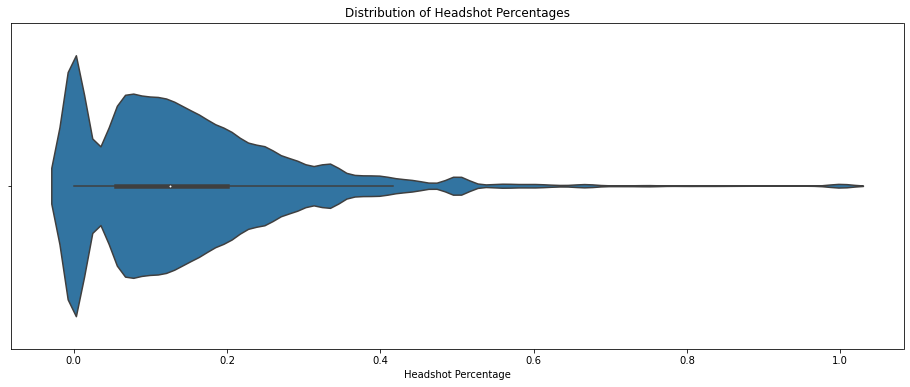

In [604]:
headshots = pd.DataFrame()

# 'Stack' the rows so that the first n rows represent Team 1's data, and the next n rows represents Team 2's data
headshots['hs_percentage'] = pd.concat([ \
                                 df_merge['Team_1_hs_percentage'], \
                                 df_merge['Team_2_hs_percentage']
                                ])

headshots['win'] = pd.concat([ \
                          df_merge['winner_team_1'], \
                          df_merge['winner_team_1'].map(lambda x: 0 if x == 1 else 1) \
                         ])

plt.figure(figsize=(16,6))
ax = sns.violinplot(x='hs_percentage', data=headshots)
ax.set_xlabel('Headshot Percentage')
ax.set_title('Distribution of Headshot Percentages')

Looking at our winrates here we notice something surprising. There doesn't actually seem to be any significant correlation between headshot percentage and winrate. Other than teams with a 0% headshot percentage having a supbar average winrate of 45%, most winrate averages don't differ from 50% too significantly. We can also discount the bins past 50% given the small sample sizes for those figures.

As a result, our data here actually seems to suggest that mechanical skill does not contribute significantly to winrate. A team only has to be "good enough" in order to have a chance at winning.

It's important to note here that 0% has a higher proportion of rounds most likely because it also includes rounds in which no one on the team hits anyone. This would decrease our winrate percentage (although in those cases, teams that fail to connect all their shots probably should have low winrate percentages...)

Text(0.5, 1.0, 'Headshot Percentage vs Win Percentage')

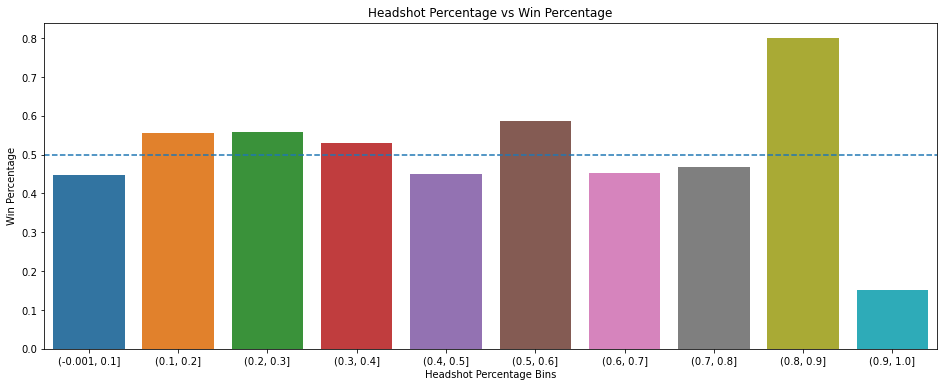

In [600]:
# Bin the data so we can calculate average win rates
headshots['bin'] = pd.cut(x=headshots['hs_percentage'], bins=10)
head_wr = headshots.groupby('bin').mean().reset_index()

plt.figure(figsize=(16,6))
ax = sns.barplot(x='bin', y='win', data=head_wr)
ax.axhline(0.5, linestyle='--')
ax.set_xlabel('Headshot Percentage Bins')
ax.set_ylabel('Win Percentage')
ax.set_title('Headshot Percentage vs Win Percentage')

# 3. Analysis

Finally, here we'll build a classification model to hopefully try and predict whether or not a team will win based on the features we just looked at. The two models that we'll be focusing on here are Logistic Regressions and Classification Trees.

We'll then evaluate our models to see if they actually can predict wins, and see which one does better.

## 3.1 Model Building

First, we're going to merge our data one last time so that we can feed it into our models. We'll do something similar to what we did in our EDA so that each row will correspond to one team in one round, with the corresponding dependent variable in the row being a dummy variable indicating whether or not the team won.

In [570]:
X = pd.DataFrame()

# 'Stack' the rows so that the first n rows represent Team 1's data, and the next n rows represents Team 2's data
X['nade_count'] = pd.concat([ \
                                 df_merge['Team_1_Nades'].map(count_nades), \
                                 df_merge['Team_2_Nades'].map(count_nades)
                                ])

X['equipment_value'] = pd.concat([ \
                                 df_merge['Team_1_Cost'], \
                                 df_merge['Team_2_Cost']
                                ])

X['hs_percentage'] = pd.concat([ \
                                 df_merge['Team_1_hs_percentage'], \
                                 df_merge['Team_2_hs_percentage']
                                ])

# Figure out if the row corresponds to a CT or T team
def team_1_side(row):
    if row['winner_team'] == 'Team 1':
        if row['winner_side'] == 'CounterTerrorist':
            return 1
        else:
            return 0
    else:
        if row['winner_side'] == 'CounterTerrorist':
            return 0
        else:
            return 1
        
temp = df_merge.apply(team_1_side, axis=1)

X['is_ct'] = pd.concat([ \
                         temp, \
                         temp.map(lambda x: 0 if x == 1 else 1) \
])

Y = pd.concat([ \
                          df_merge['winner_team_1'], \
                          df_merge['winner_team_1'].map(lambda x: 0 if x == 1 else 1) \
                         ])

Knowing how we found the equipment value and headshot percentage, we know that the missing entries correspond to entries where they couldn't be found because they didn't exist. As a result, we can just fill in headshot percentage 0 since that would be the value of the team did not hit anyone, and we can fill in equipment value with 1000 since that's the default team loadout cost for five $200 starting pistols.

In [597]:
display(X.info())
X = X.fillna({'equipment_value': 1000, 'hs_percentage': 0})

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63790 entries, 0 to 955439
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   nade_count       63790 non-null  int64  
 1   equipment_value  63790 non-null  float64
 2   hs_percentage    63790 non-null  float64
 3   is_ct            63790 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 2.4 MB


None

### Logistic Regression

Finally we can start building models! First we split our dataset into a training and test set so that our test set is 20% of our total data. Then we run our LogisticRegression, which will fit coefficients to a Logistic model. For more information on how sklearn does Logistic regression, see here: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [495]:
# Split our dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# Run Logistic Regression!
clf = LogisticRegression(random_state=0)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

# Calculate our error on our test set (MSE)
mean_squared_error(Y_pred, Y_test)

0.49192663426869415

Notice here that our MSE is 0.492.... This is not very different from 0.5 so we can probably assume that this isn't much better than randomly guessing.

### Decision Tree

Next we'll build our decision tree. When building this model, splits will be fit to our data so that it can try to predict wins from our data. For more information on how sklearn implements decision trees, see here: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html.

For more information on how to best tune the hyperparameters of a sklearn decision tree, see here:
https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680

Note that here we left most of the hyperparameters at the default, except for the splitting algorithm and the maximum depth. The splitting algorithm was set to random in order to mitigate overfitting and the max_depth was set to 300 also to reduce overfitting.

In [572]:
# Run a Decision Tree Classifier!
clf = DecisionTreeClassifier(splitter="random", max_depth=300)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

# Calculate our error on our test set (MSE)
mean_squared_error(Y_pred, Y_test)

0.3920677222135131

Our MSE with a decision tree is now 0.392! While this is nowhere near a perfect accuracy of 0, we can reasonably guess that our model is slightly better than randomly guessing. We'll try to prove this hypothesis using cross-validation and T-Testing. Of course, this is still better than Logistic Regression. We can reasonably assume that this might be the case because of interactions between our variables. For example, not using grenades may not be as big of a deal when playing as Counter-Terrorists compared to when playing as Terrorists. A Logistic Regression would have trouble modeling this kind of relationship since it is a straight-forward equation that assumes the variables are independent, while a Decision Tree might be able to capture this based on the splits made.

### Cross-Validation / Evaluation

Finally here we will evaluate our models using 10-fold cross-validation. We'll be using the KFold function from sklearn which you can read more about here: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html.

Again, the error metric that we will be using here is Mean Squared Error (MSE).

In [581]:
# Keep track of our errors for later
LogisticRegressionErrors = np.array([])
DecisionTreeErrors = np.array([])
DummyErrors = np.array([])

# Run a 10-fold cross-validation by splitting our data
kf = KFold(n_splits=10)
for train, test in kf.split(X):
    X_train = X.iloc[train]
    X_test = X.iloc[test]
    
    Y_train = Y.iloc[train]
    Y_test = Y.iloc[test]
    
    clf = LogisticRegression(random_state=0)
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)

    LRErr = mean_squared_error(Y_pred, Y_test)

    clf = DecisionTreeClassifier(splitter="random", max_depth=300)
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)

    DTCErr = mean_squared_error(Y_pred, Y_test)
    
    # Run a dummy classifier here that randomly guesses 50/50 as a benchmark
    clf = DummyClassifier(strategy='uniform').fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    
    DErr = mean_squared_error(Y_pred, Y_test)
    
    DummyErrors = np.append(DummyErrors, DErr)
    
    LogisticRegressionErrors = np.append(LogisticRegressionErrors, LRErr)
    DecisionTreeErrors = np.append(DecisionTreeErrors, DTCErr)

In [584]:
print("Logistic Regression: Error Mean: ", LogisticRegressionErrors.mean(), " standard error: ", stats.sem(LogisticRegressionErrors), "\n")
print("Decision Tree Classifier: Error Mean: ", DecisionTreeErrors.mean(), " standard error: ", stats.sem(DecisionTreeErrors), "\n")

print("Logistic Regression vs Decision Tree Classifier T-Test: \n  ", stats.ttest_rel(LogisticRegressionErrors, DecisionTreeErrors), "\n")

print("Logistic Regression T-Test: \n  ", stats.ttest_rel(LogisticRegressionErrors, DummyErrors), "\n")
print("Decision Tree Classifier T-Test: \n  ", stats.ttest_rel(DecisionTreeErrors, DummyErrors), "\n")

Logistic Regression: Error Mean:  0.4956889794638658  standard error:  0.0037448135074024513 

Decision Tree Classifier: Error Mean:  0.3943094528923029  standard error:  0.0028655502036011296 

Logistic Regression vs Decision Tree Classifier T-Test: 
   Ttest_relResult(statistic=21.79611113467614, pvalue=4.247292255033302e-09) 

Logistic Regression T-Test: 
   Ttest_relResult(statistic=-0.6490466583785744, pvalue=0.5325192574292951) 

Decision Tree Classifier T-Test: 
   Ttest_relResult(statistic=-26.926555453603903, pvalue=6.506143057934557e-10) 



Looking at our statistics above, we can fully confirm that our decision tree classifier is better than our logistic regression. Not only is the error mean lower for our decision tree, but also given that our null hypothesis is that the Logistic Regression Error = Decision Tree Error, and our alternative hypothesis is that the Logistic Regression Error > Decision Tree Error, our t-test has a p-value much lower than a standard significance level of 0.05, which suggests that we can reject the null hypothesis here.

Additionally, if we compare our results to what we would expect from a model that randomly guesses (which we approximate here by using a dummy classifier from sklearn that randomly guesses uniformly 50/50), we find that our logistic regression is not statistically significant in difference from a model that simply randomly guesses because of the high p-value (above 0.05), thus it doesn't actually do better than randomly guessing. 

On the other hand, the p-value for our Decision Tree Classifier is low enough (below 0.05 and even 0.01), that we can reject the null hypothesis that it is equivalent to randomly guessing, and state that it is actually better than randomly guessing.

To read more about the dummy classifier we used here, see here: https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

# 4. Conclusion

Looking at the analysis we've done, we've found that it's pretty clear that trying to use weapon choice, map selection, grenade count, equipment value, and headshot percentage to predict wins is nowhere near definitive. While we've found that certain choices can give a team a slight edge in winning rounds, there is no surefire way for a team to be guaranteed to win. This is further reinforced by our models, which only had a MSE of around 0.39 at best for the Decision Tree. This suggests that trying to use the variables we did to predict wins only have a slight effect on the chance to win, which is related to the idea that using these factors can only tip the round in your favor, but not win you the round.

This suggests that there are intangibles at play here that can affect winrate and other variables that we may not be looking at. One thing that can be looked at in the future is positioning, another important component to CS:GO games. Finding a way to turn positioning into a usable metric could improve our model.

However, assuming that adding more variables won't make our model significantly better, we can conclude here that CS:GO does not have any significant gimmicks that could completely swing a game in your favor. This should help comfort anyone who thinks CS:GO is an unfair game!

In summary, if you want to have that edge in winning matches: don't waste your money when you need to save, pick an AK-47 or a USP, don't play on de_nuke, train your aim so that's good enough, and practice your smoke grenades on your favorite maps (or at least use them!).

Hopefully this analysis helped give some insight into the metagame strategies of CS:GO, and some ideas on improving your chance to win. There's still more interesting work to be done like heatmaps for positioning, but hopefully this was a good start into the world of CS:GO!

I hope this was an interesting and educational tutorial (and should you choose to play CS:GO, improve your win rate as well)!